In [5]:
import os
import sys
sys.path.append(f"{os.getcwd()}/..")


In [6]:
%load_ext autoreload
%autoreload 2

from geographiclib.geodesic import Geodesic
import math
from aircraft_env import Location
import pandas as pd
from aircraft_env import AircraftEnv
from utils.geodesic import Location, bearing2coords
from q_learning_agent import QTableAgent
from utils.env_extra import env_summary
geod = Geodesic.WGS84  # define the WGS84 ellipsoid



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# from  geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent='myapplication')
# # city ="Agra"
# # country ="India"
# loc_1 = geolocator.geocode('Montréal–Trudeau International Airport')
# print("latitude is :-" ,loc_1.latitude,"\nlongtitude is:-" ,loc_1.longitude)

# loc_2 = geolocator.geocode('Charles de Gaulle Airport')
# print("latitude is :-" ,loc_2.latitude,"\nlongtitude is:-" ,loc_2.longitude)
loc_1 = Location(45.46873715, -73.74257166095532)
loc_2 = Location(49.0068908, 2.5710819691019156)
loc_1, loc_2
env = AircraftEnv(arrival_location=loc_1, destination=loc_2, n_waypoints=9)

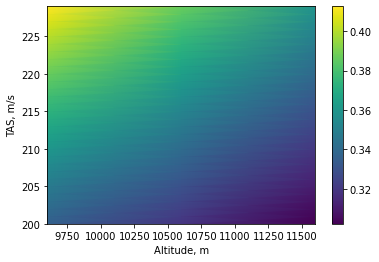

In [40]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from utils.units_converter import mperstokt, meter2feet
import numpy as np
TAS =   (np.arange(200, 230))
altitudes = np.arange(env.cruise_alt_min,env.cruise_alt_max, 1000)
FF = np.empty((TAS.shape[0], altitudes.shape[0]))
for i, tas in enumerate(TAS):
    FF[i, :] = env.aicraft.fuel_enroute(30000, mperstokt(tas), meter2feet(altitudes), 0)

     
plt.pcolormesh(altitudes, TAS, FF, shading='gouraud')
plt.xlabel("Altitude, m")
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.ylabel("TAS, m/s")
# plt.title(fontweight ="bold")

plt.colorbar()
plt.savefig('FF.png')
plt.show()

In [3]:
agent = QTableAgent(env,  episode_number=10000,  epsilon_delta=3000, mach_delta=0.01, checkpoint='saved_models/saved_6.npy')


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

States (Trajectory, Waypoints, Altitude) 5 x 9 x 8 / 360
Action (Trajectory, Altitude Step, Mach Number) 5 x 5 x 6 / 360
Q Table (5, 9, 8, 5, 5, 6) / 54000


In [4]:
df = env_summary(env, agent)
df

,trajectory,waypoint,speed,tas,distance,wind_magnitude,wind_direction,course,correction_angle,altitude,time_for_distance,fuel_burn,total_time,reward,fuel_flow
0,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0
1,2,1,229.291911,228.530242,692678.387980,0.786193,71.027558,56.703470,-0.048766,10609.6,3020.945588,643.232946,3020.945588,-643.232946,0.21292437335033065
2,1,2,227.462038,227.592005,694429.134740,1.153902,322.006729,58.329457,0.288726,10000.0,3052.945189,648.369170,6073.890777,-648.369170,0.21237497892027346
3,0,3,226.157974,226.582650,694421.546201,2.709053,326.163992,64.844214,0.677205,9390.4,3070.515418,650.179311,9144.406195,-650.179311,0.21174924140378976
4,0,4,224.636963,224.597374,692627.408837,7.561789,165.255611,76.520012,-1.928940,10000.0,3083.318963,646.253827,12227.725158,-646.253827,0.20959681259324422
5,1,5,238.858066,239.570532,694457.953821,7.021223,184.117391,89.130542,-1.673080,10000.0,2907.408431,652.738803,15135.133589,-652.738803,0.22450880846378923
6,1,6,220.798025,224.597374,692674.276029,3.820945,279.880104,93.733036,0.104376,10000.0,3137.139816,657.534506,18272.273406,-657.534506,0.20959681259324422
7,2,7,229.060671,228.530242,694448.566594,1.565769,176.332651,106.318673,-0.368922,10609.6,3031.723275,645.527779,21303.996681,-645.527779,0.21292437335033065
8,0,8,233.640359,230.154205,692678.387980,3.658361,127.339210,109.825991,-0.274064,11219.2,2964.720616,634.733983,24268.717297,-634.733983,0.2140957158672867


In [5]:
df['fuel_burn'].sum()

5178.57032381799

In [6]:
def add_points_to_map(m, waypoints, color='red'):
    for waypoint in waypoints:
        folium.CircleMarker(
            radius=1,
          location=[waypoint.latitude, waypoint.longitude],
    #       icon=folium.Icon(color="red",icon="star", prefix='fa')
            color=color
        ).add_to(m)
        
def _add_wind(m, wind_dir, wp_lat, wp_lon, wind):
    wind_lat, wind_lon = bearing2coords(wind_dir, wp_lat, wp_lon, 1000*wind)
    folium.PolyLine([[wp_lat, wp_lon], [wind_lat, wind_lon]], color="green", weight=1, opacity=3).add_to(m)
    folium.RegularPolygonMarker(location=[wind_lat, wind_lon], fill_color='green', number_of_sides=1, radius=1.5).add_to(m)
    
def add_winds(m, waypoints, winds_dirs, wind_magnitude):
    for i, wp in enumerate(waypoints):
        wind_dir = winds_dirs[len(winds_dirs) // 2][i]
        wind = wind_magnitude[len(wind_magnitude) // 2][i]
        _add_wind(m, wind_dir, wp.latitude, wp.longitude, wind)
        
def selected_trajectory(env: AircraftEnv, trajectory):
    return [env.waypoints[trajectory[i]][i] for i in range(len(trajectory))]

In [7]:
# import the library
import folium
import itertools

# Make an empty map
m = folium.Map(location=env._waypoints_to_array()[env.n_routes // 2][env.n_waypoints // 2], tiles="OpenStreetMap", zoom_start=4, min_zoom=4, max_zoom = 6)
locations = [loc_1, loc_2]
ar_waypoints = env._waypoints_to_array()
for loc in locations:
    
    folium.Marker(
      location=[loc.latitude, loc.longitude],
      popup=str(loc),
    ).add_to(m)
# waypoints = env._waypoints_to_array()
# new_route = list(itertools.chain(*[generate_new_route_2(env.waypoints[1:-1], x[0], x[1]) for x in [(90, 50e3), (90, 100e3), (270, 50e3), (270, 100e3)]]))

for i, traj in enumerate(env.waypoints):
    color = 'blue' if i == env.n_routes // 2 else 'green'
    add_points_to_map(m, traj[1:-1], color=color)
    folium.PolyLine(ar_waypoints[i], color=color, weight=1, opacity=3).add_to(m)

current_trajectory =  selected_trajectory(env, df['trajectory'])
add_points_to_map(m, current_trajectory, color='red')
folium.PolyLine([[wp.latitude, wp.longitude] for wp in current_trajectory], color='red', weight=1, opacity=3).add_to(m)

# folium.PolyLine(ar_waypoints[i], color=color, weight=1, opacity=3).add_to(m)
# new_route = np.array([[wp.latitude, wp.longitude] for wp in new_route])


# folium.PolyLine(env._waypoints_to_array(), color="blue", weight=1, opacity=3).add_to(m)
# folium.PolyLine(new_route, color="red", weight=1, opacity=3).add_to(m)

# add_winds(m, env.main_trajectory, env._wind_direction, env._wind_magnitude)

m

In [8]:
df

,trajectory,waypoint,speed,tas,distance,wind_magnitude,wind_direction,course,correction_angle,altitude,time_for_distance,fuel_burn,total_time,reward,fuel_flow
0,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0
1,2,1,229.291911,228.530242,692678.387980,0.786193,71.027558,56.703470,-0.048766,10609.6,3020.945588,643.232946,3020.945588,-643.232946,0.21292437335033065
2,1,2,227.462038,227.592005,694429.134740,1.153902,322.006729,58.329457,0.288726,10000.0,3052.945189,648.369170,6073.890777,-648.369170,0.21237497892027346
3,0,3,226.157974,226.582650,694421.546201,2.709053,326.163992,64.844214,0.677205,9390.4,3070.515418,650.179311,9144.406195,-650.179311,0.21174924140378976
4,0,4,224.636963,224.597374,692627.408837,7.561789,165.255611,76.520012,-1.928940,10000.0,3083.318963,646.253827,12227.725158,-646.253827,0.20959681259324422
5,1,5,238.858066,239.570532,694457.953821,7.021223,184.117391,89.130542,-1.673080,10000.0,2907.408431,652.738803,15135.133589,-652.738803,0.22450880846378923
6,1,6,220.798025,224.597374,692674.276029,3.820945,279.880104,93.733036,0.104376,10000.0,3137.139816,657.534506,18272.273406,-657.534506,0.20959681259324422
7,2,7,229.060671,228.530242,694448.566594,1.565769,176.332651,106.318673,-0.368922,10609.6,3031.723275,645.527779,21303.996681,-645.527779,0.21292437335033065
8,0,8,233.640359,230.154205,692678.387980,3.658361,127.339210,109.825991,-0.274064,11219.2,2964.720616,634.733983,24268.717297,-634.733983,0.2140957158672867


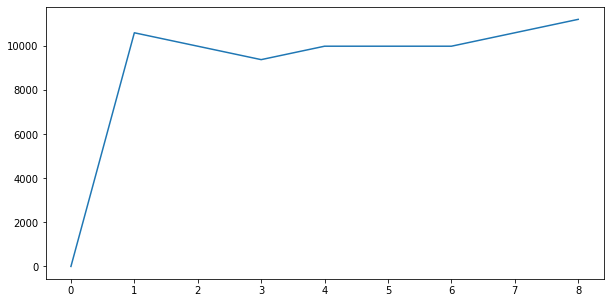

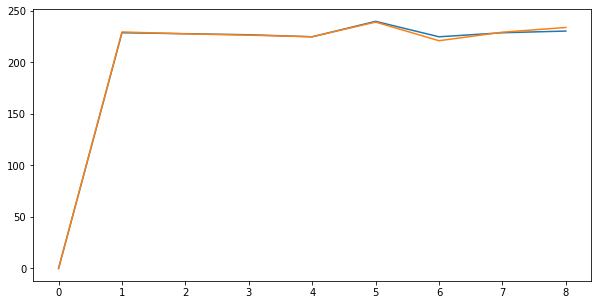

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams["figure.figsize"] = (10,5)

df['altitude'].plot()#rolling(window = 10).mean().plot()
plt.show()
df['tas'].plot()
df['speed'].plot()
plt.show()

# pd.Series(rewards).rolling(window =100).mean().plot()
# plt.show()